In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from tensorflow.keras.models import Sequential
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.layers import Dense, Dropout
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score

In [2]:
# Load the dataset
df = pd.read_csv("PS_20174392719_1491204439457_log.csv")

In [3]:
# Display the first few rows of the dataset
print("First 5 rows of the dataset:")
print(df.head())

First 5 rows of the dataset:
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [4]:
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [5]:
# Exploratory Data Analysis (EDA)
print("\nDataset Summary:")
print(df.describe())


Dataset Summary:
               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04   1.420800e+04    0.000000e+00   
75%    3.350000e+02  2.087215e+05   1.073152e+05    1.442584e+05   
max    7.430000e+02  9.244552e+07   5.958504e+07    4.958504e+07   

       oldbalanceDest  newbalanceDest       isFraud  isFlaggedFraud  
count    6.362620e+06    6.362620e+06  6.362620e+06    6.362620e+06  
mean     1.100702e+06    1.224996e+06  1.290820e-03    2.514687e-06  
std      3.399180e+06    3.674129e+06  3.590480e-02    1.585775e-03  
min      0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00  
25%      0.000000e+

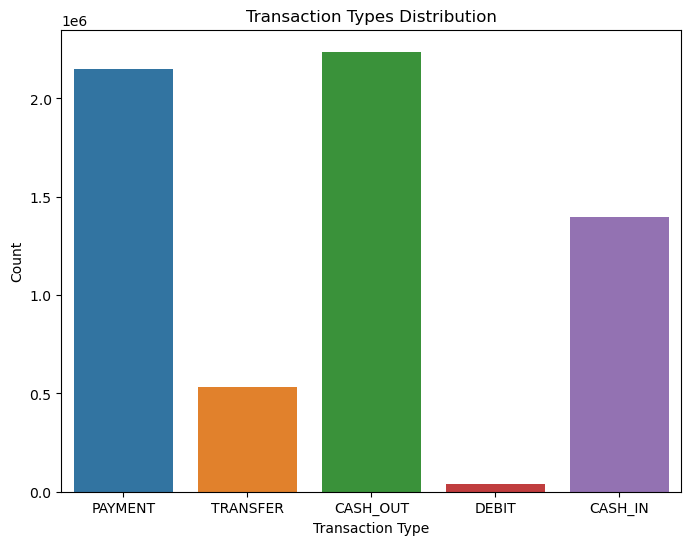

In [6]:
# Visualizing the distribution of transactions types
plt.figure(figsize=(8, 6))
sns.countplot(x='type', data=df)
plt.title('Transaction Types Distribution')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show()

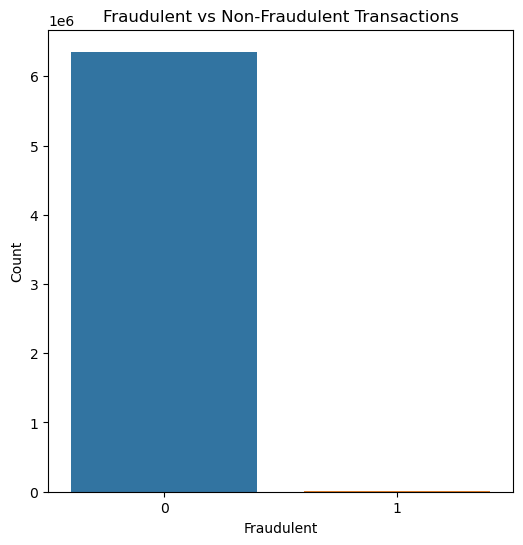

In [7]:
# Visualizing fraud vs non-fraud transactions
plt.figure(figsize=(6, 6))
sns.countplot(x='isFraud', data=df)
plt.title('Fraudulent vs Non-Fraudulent Transactions')
plt.xlabel('Fraudulent')
plt.ylabel('Count')
plt.show()

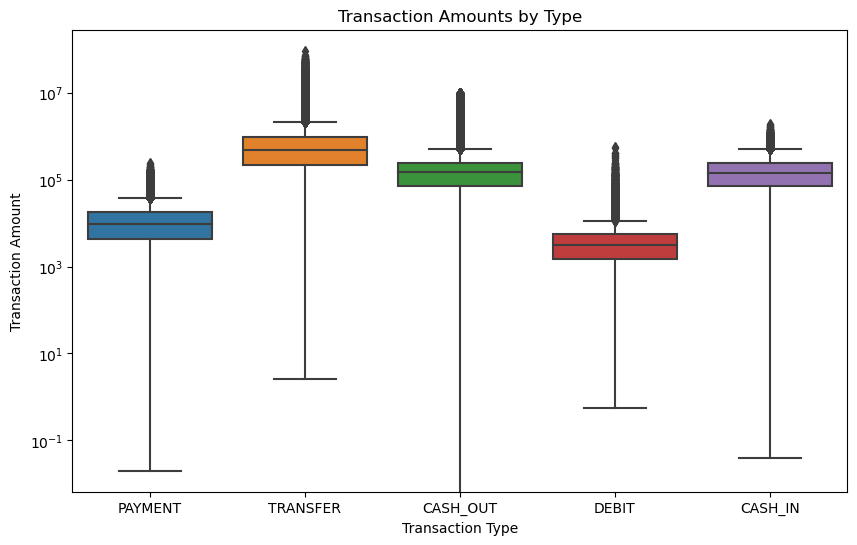

In [8]:
# Boxplot for transaction amounts by type
plt.figure(figsize=(10, 6))
sns.boxplot(x='type', y='amount', data=df)
plt.title('Transaction Amounts by Type')
plt.xlabel('Transaction Type')
plt.ylabel('Transaction Amount')
plt.yscale('log')
plt.show()

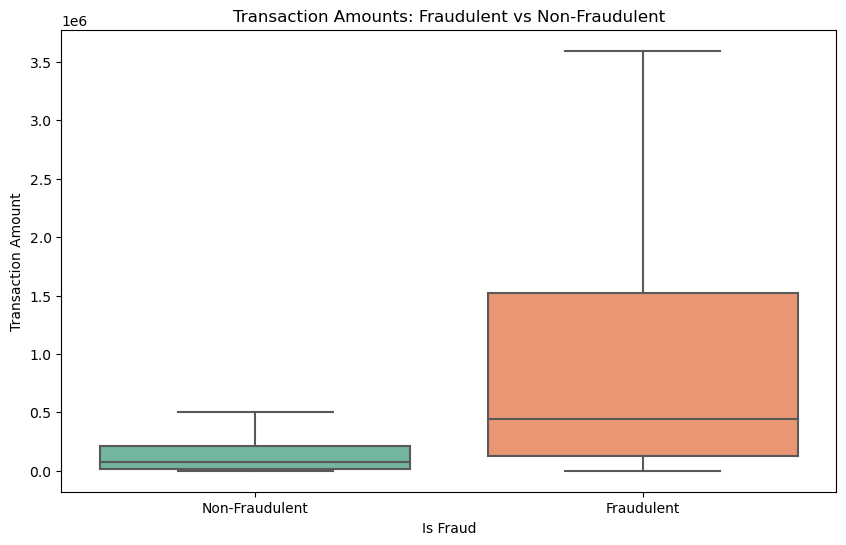

In [13]:
# Box plot to analyze the amounts for fraudulent and non-fraudulent transactions
plt.figure(figsize=(10, 6))
sns.boxplot(x="isFraud", y="amount", data=df, showfliers=False, palette="Set2")
plt.title("Transaction Amounts: Fraudulent vs Non-Fraudulent")
plt.xlabel("Is Fraud")
plt.ylabel("Transaction Amount")
plt.xticks([0, 1], ["Non-Fraudulent", "Fraudulent"])
plt.show()

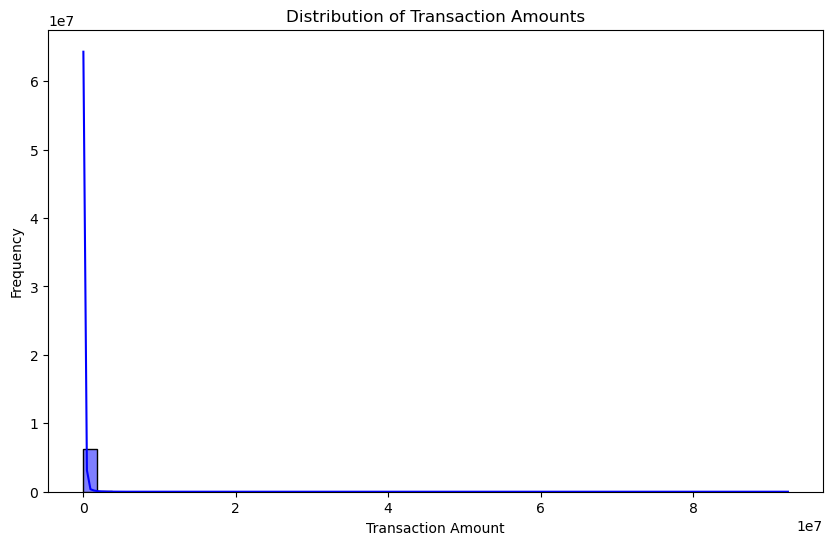

In [14]:
# Distribution of transaction amounts
plt.figure(figsize=(10, 6))
sns.histplot(df["amount"], bins=50, kde=True, color="blue")
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.show()

In [15]:
# Encode categorical features
df['type'] = LabelEncoder().fit_transform(df['type'])

In [16]:
# Feature Engineering: Create new features
df['errorOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig'] - df['amount']
df['errorDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']

In [17]:
# Drop irrelevant columns
df = df.drop(['nameOrig', 'nameDest'], axis=1)

In [18]:
# Preprocessing: Define features and target
X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df['isFraud']

In [19]:
# Handle class imbalance using upsampling
df_majority = df[df.isFraud == 0]
df_minority = df[df.isFraud == 1]

df_minority_upsampled = resample(df_minority, 
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=42)

df_upsampled = pd.concat([df_majority, df_minority_upsampled])
X = df_upsampled.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df_upsampled['isFraud']

In [20]:
# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [23]:
# Model Training and Evaluation
# Logistic Regression
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)
y_pred_logistic = logistic_model.predict(X_test)
y_prob_logistic = logistic_model.predict_proba(X_test)[:, 1]

print("\nLogistic Regression Evaluation:")
print(classification_report(y_test, y_pred_logistic))
print(f"AUC-ROC: {roc_auc_score(y_test, y_prob_logistic):.4f}")


Logistic Regression Evaluation:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92   1906339
           1       0.96      0.88      0.92   1906306

    accuracy                           0.92   3812645
   macro avg       0.92      0.92      0.92   3812645
weighted avg       0.92      0.92      0.92   3812645

AUC-ROC: 0.9736


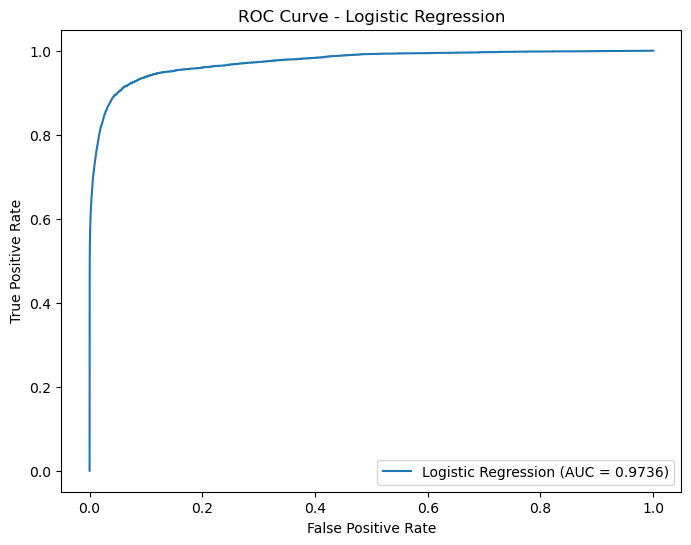

In [24]:
# Plot ROC curve for Logistic Regression
fpr, tpr, _ = roc_curve(y_test, y_prob_logistic)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="Logistic Regression (AUC = {:.4f})".format(roc_auc_score(y_test, y_prob_logistic)))
plt.title('ROC Curve - Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [32]:
# Neural Network Model
nn_model = Sequential([
    Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])

nn_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
nn_model.fit(X_train, y_train, epochs=3, batch_size=64, validation_split=0.2, verbose=1)

Epoch 1/3
111203/111203 ━━━━━━━━━━━━━━━━━━━━ 309s 3ms/step - accuracy: 0.9834 - loss: 0.0492 - val_accuracy: 0.9911 - val_loss: 0.0267
Epoch 2/3
111203/111203 ━━━━━━━━━━━━━━━━━━━━ 311s 3ms/step - accuracy: 0.9910 - loss: 0.0291 - val_accuracy: 0.9942 - val_loss: 0.0202
Epoch 3/3
111203/111203 ━━━━━━━━━━━━━━━━━━━━ 323s 3ms/step - accuracy: 0.9914 - loss: 0.0278 - val_accuracy: 0.9927 - val_loss: 0.0229


In [33]:
# Neural Network Evaluation
nn_predictions = (nn_model.predict(X_test) > 0.5).astype("int32")
print("Performance of Neural Network:")
print("Accuracy:", accuracy_score(y_test, nn_predictions))

119146/119146 ━━━━━━━━━━━━━━━━━━━━ 195s 2ms/step
Performance of Neural Network:
Accuracy: 0.99263162450215


119146/119146 ━━━━━━━━━━━━━━━━━━━━ 175s 1ms/step


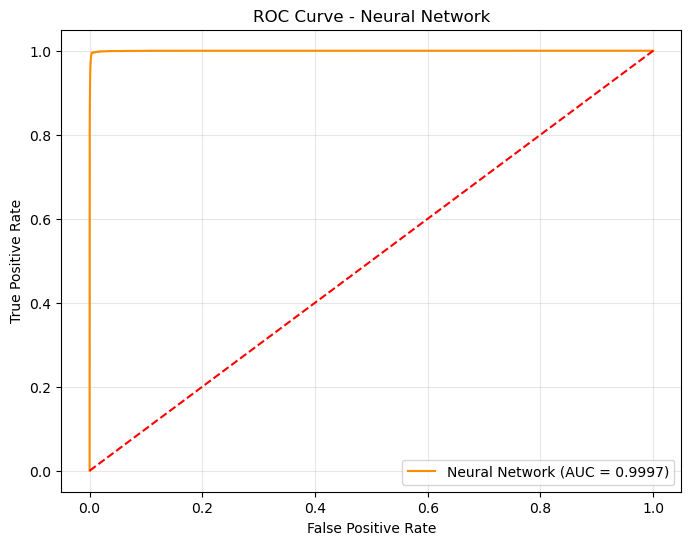

In [35]:
# Predict probabilities for AUC-ROC calculation
nn_probabilities = nn_model.predict(X_test)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, nn_probabilities)
auc_score = roc_auc_score(y_test, nn_probabilities)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Neural Network (AUC = {auc_score:.4f})", color="darkorange")
plt.plot([0, 1], [0, 1], "r--")
plt.title("ROC Curve - Neural Network")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [38]:
# Calculate ROC for Logistic Regression
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_prob_logistic)
auc_logistic = roc_auc_score(y_test, y_prob_logistic)

# Calculate ROC for Neural Network
fpr_nn, tpr_nn, _ = roc_curve(y_test, nn_probabilities)
auc_nn = roc_auc_score(y_test, nn_probabilities)

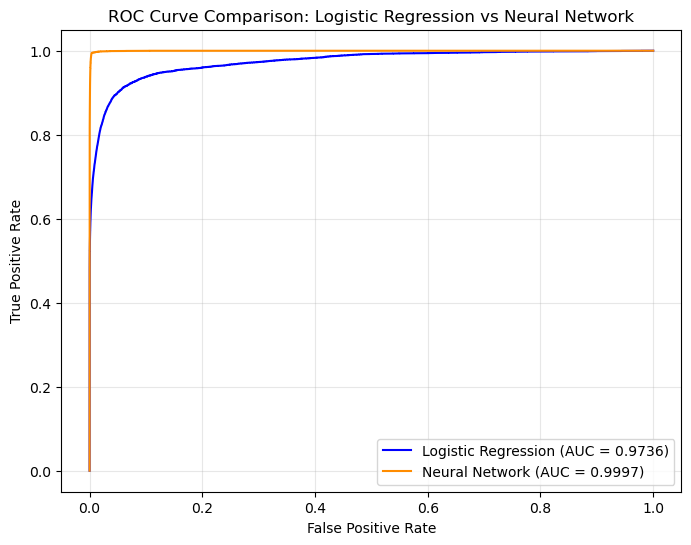

In [43]:
# Plot the comparison
plt.figure(figsize=(8, 6))
plt.plot(fpr_logistic, tpr_logistic, label=f"Logistic Regression (AUC = {auc_logistic:.4f})", color="blue")
plt.plot(fpr_nn, tpr_nn, label=f"Neural Network (AUC = {auc_nn:.4f})", color="darkorange")

# Adding plot details
plt.title("ROC Curve Comparison: Logistic Regression vs Neural Network")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()